In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


ROOT_DIR = os.path.abspath("../")
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

from matterport import utils
from matterport import visualize
from matterport.visualize import display_images
import matterport.model as modellib
from matterport.model import log
from model.model import RoofTypeConfig
from model.dataset import RoofTypeDataset

Using TensorFlow backend.


## Config and Dataset

In [2]:
config = RoofTypeConfig()
ROOFS_DIR = os.path.join(ROOT_DIR, "resources/images/chips/sparse_train_test_val/test")
dataset = RoofTypeDataset()
dataset.load_data(ROOFS_DIR)
dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 3318
Class Count: 7
  0. BG                                                
  1. 1000                                              
  2. 2100                                              
  3. 3100                                              
  4. 3200                                              
  5. 3300                                              
  6. 3400                                              


## Display Samples

Load and display images and masks.

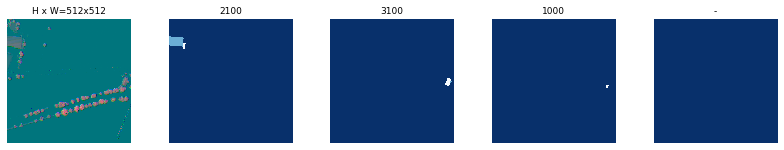

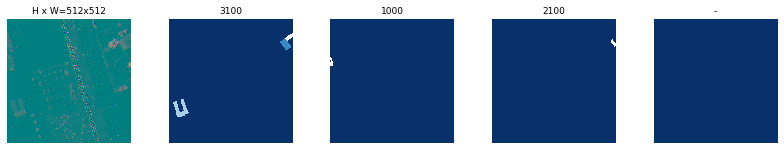

In [19]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

image_id  1212 C:\Users\MoritzWollenhaupt\Desktop\Masterarbeit\resources/images/chips/sparse_train_test_val/test\000115137\000115137.tif
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    2.00000  max:    3.00000  int32
bbox                     shape: (2, 4)                min:  305.00000  max:  486.00000  int32


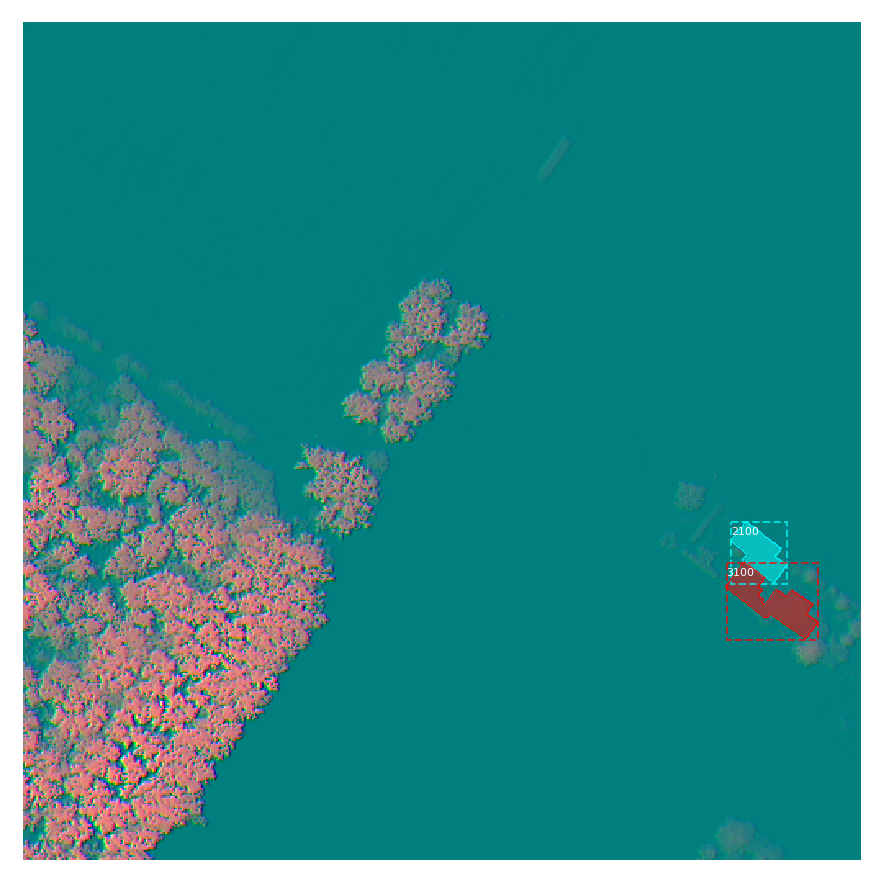

In [34]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 1212.00000  int32
class_ids                shape: (2,)                  min:    2.00000  max:    3.00000  int32
bbox                     shape: (2, 4)                min:  305.00000  max:  486.00000  int32
mask                     shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool


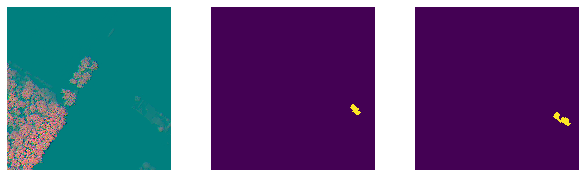

In [35]:
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


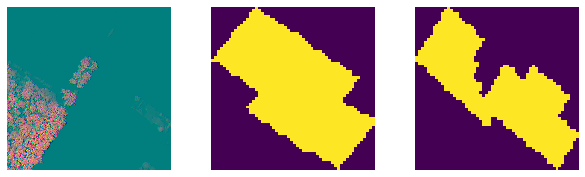

In [36]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 11))])

## Anchors

In [37]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (10, 20, 40, 80, 160)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


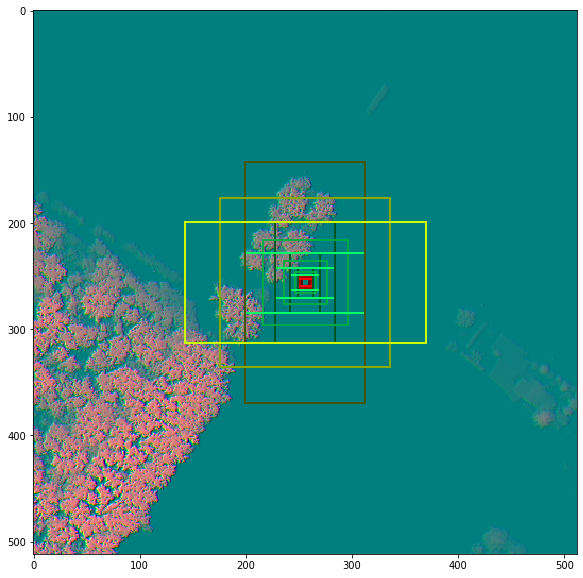

In [38]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [30]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 1024, 4)          min:    0.00000  max:  511.00000  int32
mrcnn_class_ids          shape: (4, 1024, 1)          min:    0.00000  max:    6.00000  int32
mrcnn_bbox               shape: (4, 1024, 7, 4)       min:   -3.34525  max:    3.12500  float32
mrcnn_mask               shape: (4, 1024, 28, 28, 7)  min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    6.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  512.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -2.00000  max:    2.84859  float64
image_id:  303 C:\Users\MoritzWollenhaupt\Desktop\Masterarbeit\resources/images/chips/sparse_train_test_val/test\000028945\000028945.tif


anchors                  shape: (65472, 4)            min: -113.13708  max:  561.13708  float64
refined_anchors          shape: (12, 4)               min:    0.00000  max:  512.00000  float32
Positive anchors: 12
Negative anchors: 244
Neutral anchors: 65216
BG                     : 999
1000                   : 4
2100                   : 18
3100                   : 3


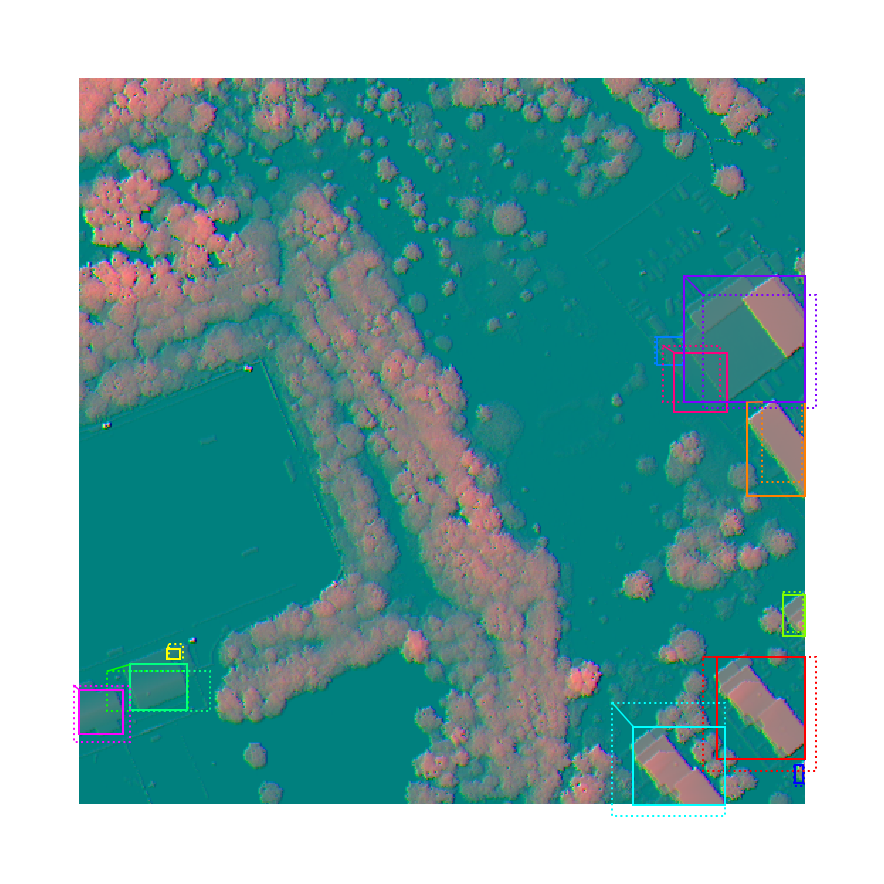

In [41]:
b = 0

# Restore original image (reverse normalization)
#sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

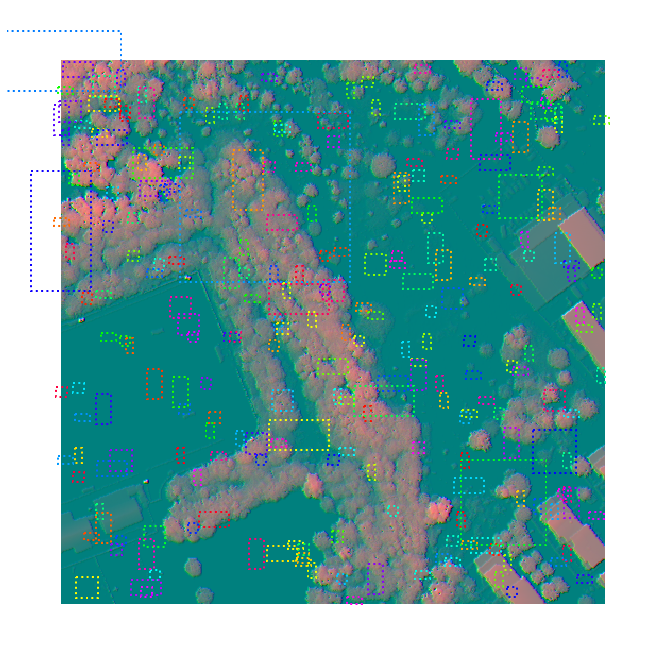

In [42]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

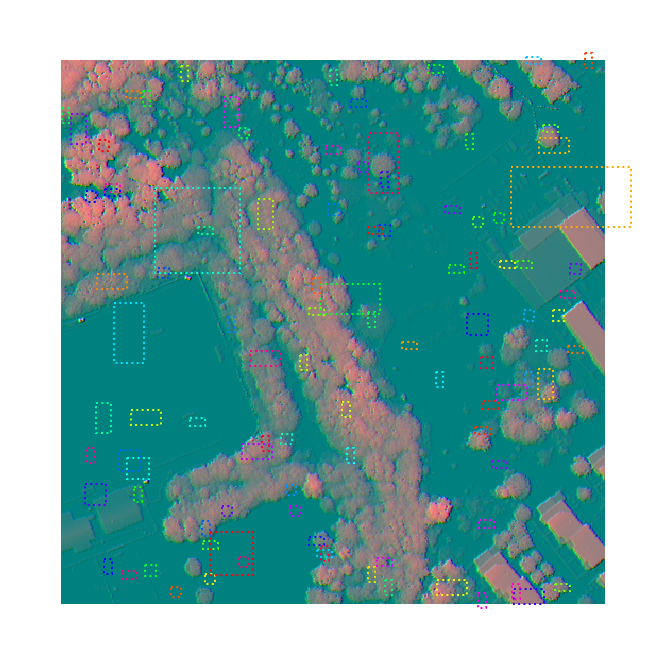

In [43]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  25
Negative ROIs:  999
Positive Ratio: 0.02
Unique ROIs: 1024 out of 1024


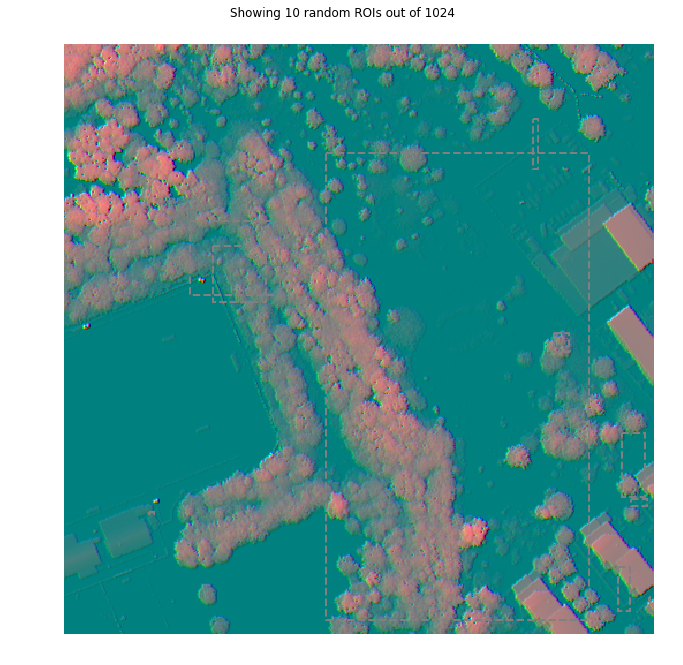

In [46]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [48]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   93  0.09
  164  0.16
  141  0.14
  114  0.11
  185  0.18
  126  0.12
  105  0.10
   96  0.09
  172  0.17
  164  0.16
Average percent: 0.13
